In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import radians, cos, sin, asin, sqrt

In [2]:
class BoundingBox(object):
    
    def __init__(self, lat_min, lat_max, long_min, long_max):
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.long_min = long_min
        self.long_max = long_max
        
    def contains(self, lat, long):
        return self.lat_min <= lat <= self.lat_max and self.long_min <= long <= self.long_max

In [3]:
class BoundingBoxSet(object):
    
    def __init__(self, boxes=[]):
        self.boxes = boxes
        
    def init_from_histogram(self, h, xedges, yedges, tolerance):
        """
        consumes h, xedged, yedges variables provided by matplotlib.pyplot.hist2d
        and constructs the bounding boxes according to the specified tolerance
        """
        
        if len(self.boxes) > 0:
            warnings.warn("BoundingBoxSet has been previously initialized, setting self.boxes = []")
            self.boxes = []
        
        rows = h.shape[0]
        cols = h.shape[1]
        
        for row in range(rows):
            for col in range(cols):
                if h[row][col] > tolerance:
                    long_min = xedges[row]
                    long_max = xedges[row+1]
                    lat_min = yedges[col]
                    lat_max = yedges[col+1]

                    self.boxes.append(BoundingBox(lat_min, lat_max, long_min, long_max))


In [4]:
def check_location_against_bbox_set(row, bbox_set):
    """
    Check if a provided location is contained in any of the boundingboxes
    Return true if it is, flase otherwise
    """
    
    for box in bbox_set.boxes:
        if box.contains(row['gpslat'], row['gpslong']):
            return True  
    return False

In [5]:
def check_tolerances_dataset(data, bbox_set):
    data.loc[:, 'is_in_tolerance_area'] = data.apply(check_location_against_bbox_set, args=[bbox_set], axis=1)
    return data

In [6]:
def build_sample_indices(data, col):
    """
    Builds sequence indices based on duration data
    Iterate over the rows in data and increment index whenever duration == 0
    
    Args:
        data (pd.DataFrame) : The dataframe whose indices are to be built.
        col (string) : The column of the dataframe with respect to the indexing
    Returns:
         data (pd.Series) : Data with an added column for the sequence indices
    """
    
    idx = 0
    seq_indices = []
    for _, row in data.iterrows():
        if row[col] == 0:
            #increment index and begin new sequence
            idx += 1
            seq_indices.append(idx)
        else:
            seq_indices.append(idx)
    
    data['sequence'] = seq_indices
    
    return data

In [7]:
def drop_sequences(data, cond_col, condition, threshold):
    """
    Drop sequences including > threshold rows where the column
    cond_col evaluates to condition
    
    Args:
        data (pd.DataFrame) : data to be checked
        cond_col (string) : the name of the column to be checked for a logical condition
        condition (bool) : The condition
        threshold (int) : occurence threshold for removing the sequence
    Returns:
        data_dropped (pd.DataFrame) : data where the affected rows have been dropped
    """
    seq_ids = list(data['sequence'].unique())
    to_be_dropped = []
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        try:
            if seq[cond_col].value_counts()[condition] > threshold:
                to_be_dropped.append(seq.index.tolist())
        except:
            pass
        
    to_be_dropped = [idx for seq in to_be_dropped for idx in seq]
    data_dropped = data.drop(to_be_dropped) 
    return data_dropped


In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [9]:
def compute_distance_between_rows(row1, row2, gpslat_col, gpslong_col):
    """
    Compute the haversine distance given two rows sliced from a pd.DataFrame.
    Rows are expected to be identical in their columns
    
    Args:
        row1 (pd.Series of shape (1, n_features)) 
        row2 (pd.Series of shape (1, n_features))
        gpslat_col (string) : the identifier of the column of gps latitude in both rows
        gpslong_col (string) : the identifier of the column of gps longitude in both rows
    
    Returns:
        distance (float)
    """
    lon1 = row1[gpslong_col]
    lat1 = row1[gpslat_col]
    lon2 = row2[gpslong_col]
    lat2 = row2[gpslat_col]
        
    return haversine(lon1, lat1, lon2, lat2)


In [10]:
def convert_sequence_to_relative(seq):
    """
    Converts gpslat, gpslong and altitude to running relative metrics
    
    Args:
        seq (pd.DataFrame) : the sequence to be converted
    
    Returns:
        distance (pd.Series) : running distance offset (meters) from the beginning of the series
        rel_altitude (pd.Series) : running altitude offset (meters) from the beginning of the series
        rel_soc (pd.Series) : the additive inverse of SOC offset from beginning of the series
    """
    first_row = seq.iloc[0,:]
    args = (first_row, 'gpslat', 'gpslong')
    
    distance = seq.apply(compute_distance_between_rows, args=args, axis=1)
    rel_altitude = seq.apply(lambda row : row['altitude'] - first_row['altitude'], axis=1)
    rel_soc = seq.apply(lambda row : -1*(row['soc'] - first_row['soc']), axis=1)
    
    return distance, rel_altitude, rel_soc


In [11]:
def convert_dataset_to_relative(data):
    """
    Iterate over sequences in the whole dataset and make the necessary conversions
    """
    seq_ids = list(data['sequence'].unique())
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        distance, rel_altitude, rel_soc = convert_sequence_to_relative(seq)
        data.loc[seq.index, 'distance'] = distance
        data.loc[seq.index, 'rel_altitude'] = rel_altitude
        data.loc[seq.index, 'rel_soc'] = rel_soc
    
    data = data.drop(['gpslat', 'gpslong', 'altitude', 'soc'], axis=1)
    
    return data


In [16]:
def preprocess_dataset(data, bins, threshold):
    h, xedges, yedges, _ = plt.hist2d(data['gpslong'], data['gpslat'], bins=bins)
    bbox_set = BoundingBoxSet()
    bbox_set.init_from_histogram(h, xedges, yedges, 1)
    
    #Apply transformations
    data = check_tolerances_dataset(data, bbox_set)
    data = build_sample_indices(data, 'duration')
    data = drop_sequences(data, 'is_in_tolerance_area', False, threshold=threshold)
    data = convert_dataset_to_relative(data)
    
    data = data.drop('is_in_tolerance_area', axis = 1)
    data = data.drop('timestamp', axis = 1)
    
    return data
    

-----------------

In [13]:
data = pd.read_csv('./data/dummy_data.csv')

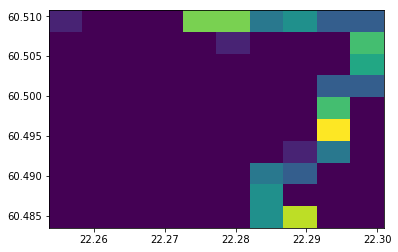

In [14]:
transformed_data = preprocess_dataset(data, 10, 0)

In [15]:
transformed_data

,timestamp,speed,temp,duration,sequence,distance,rel_altitude,rel_soc
11,2017-01-01 12:08:30,21.640625,-0.835443,0,2,0.000000,0.000000,-0.000000
12,2017-01-01 12:08:35,34.296875,-0.851266,5,2,0.053487,-0.292448,0.200000
13,2017-01-01 12:08:40,38.804688,-0.867089,10,2,0.108692,-0.606137,0.360000
14,2017-01-01 12:08:45,39.445312,-0.882911,15,2,0.167016,-0.654427,0.400000
15,2017-01-01 12:08:50,38.101562,-0.898734,20,2,0.232565,-0.592763,0.350000
16,2017-01-01 12:08:55,26.511719,-0.914557,25,2,0.232565,-0.592763,0.286667
17,2017-01-01 12:09:00,20.085938,-0.930380,30,2,0.272694,-1.522142,0.253333
18,2017-01-01 12:09:05,30.421875,-0.946203,35,2,0.298685,-2.115871,0.420000
19,2017-01-01 12:09:10,42.367188,-0.962025,40,2,0.329746,-1.843151,0.720000
20,2017-01-01 12:09:15,44.449219,-0.977848,45,2,0.390133,-1.727719,0.820000


In [21]:
data = pd.read_csv('./data/trips_bulk.csv')

In [22]:
data = data[0:100000]

C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: BoundingBoxSet has been previously initialized, setting self.boxes = []
  del sys.path[0]


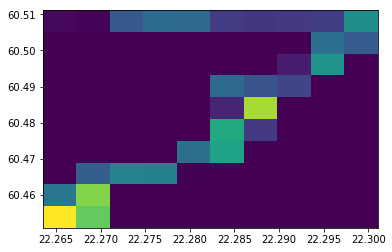

In [23]:
trans_data = preprocess_dataset(data, 10, 0)

In [24]:
trans_data

,speed,temp,duration,sequence,distance,rel_altitude,rel_soc
0,25.570312,-0.661392,0,1,0.000000,0.000000,-0.000000
1,27.574219,-0.677215,5,1,0.040666,-0.696062,0.096667
2,30.535156,-0.693038,10,1,0.092468,-1.234818,0.196667
3,31.160156,-0.708861,15,1,0.142041,-1.711705,0.283333
4,34.199219,-0.724684,20,1,0.186323,-3.369781,0.376667
5,32.167969,-0.740506,25,1,0.186323,-3.369781,0.450000
6,33.433594,-0.756329,30,1,0.227814,-3.107569,0.505556
7,35.300781,-0.772152,35,1,0.267211,-3.755753,0.466667
8,31.132812,-0.787975,40,1,0.314702,-6.448910,0.396667
9,17.683594,-0.803797,45,1,0.363916,-6.762090,0.327778


In [25]:
data.to_csv('./data/midsize_dummy_preprocessed.csv', index=False)